* IDR optimal peak set: 129442 peaks "/srv/scratch/annashch/dmso/raw_data/"
* input: fc signal strength for the pooled pseudo replicates over the IDR peaks 

In [ ]:
rm(list=ls())
library(limma)
library(sva)
library(ggplot2)

In [8]:
data=data.frame(read.table('atac.counts.prededup.txt',header=TRUE,sep='\t'))
chrom=data$Chrom
start_pos=data$Start
end_pos=data$End
unique_names=paste(chrom,start_pos,end_pos,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL
rownames(data)=unique_names


In [9]:
batches=data.frame(read.table('../atacseq_batches_truerep.txt',header=TRUE,sep='\t'))
mod1=model.matrix(~0+Treatment+CellCycle,data=batches)
v=voom(counts=data,design=mod1)

In [10]:
batches


Replicate,Sample,CellCycle,Treatment
earlyG1_controls_Rep1,earlyG1_controls,earlyG1,controls
earlyG1_controls_Rep2,earlyG1_controls,earlyG1,controls
earlyG1_DMSO_Rep1,earlyG1_DMSO,earlyG1,DMSO
earlyG1_DMSO_Rep2,earlyG1_DMSO,earlyG1,DMSO
lateG1_controls_Rep1,lateG1_controls,lateG1,controls
lateG1_controls_Rep2,lateG1_controls,lateG1,controls
lateG1_DMSO_Rep1,lateG1_DMSO,lateG1,DMSO
lateG1_DMSO_Rep2,lateG1_DMSO,lateG1,DMSO
SG2M_controls_Rep1,SG2M_controls,SG2M,controls
SG2M_controls_Rep2,SG2M_controls,SG2M,controls


In [11]:
data_corrected=v$E


[1] 1.740617e+01 1.209337e+01 1.069054e+01 9.304712e+00 8.278382e+00
 [6] 8.142253e+00 7.618644e+00 7.438642e+00 6.614982e+00 6.396028e+00
[11] 6.016282e+00 9.942328e-28

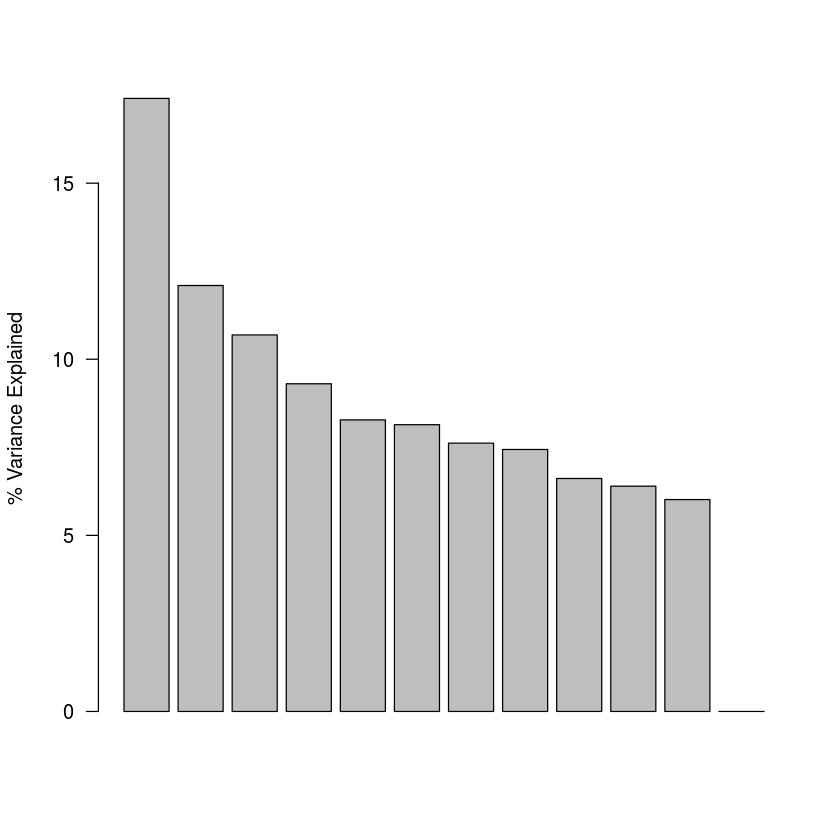

In [12]:
data.pca=prcomp(t(data_corrected))

barplot(100*data.pca$sdev^2/sum(data.pca$sdev^2),las=2,xlab="",ylab="% Variance Explained")
100*data.pca$sdev^2/sum(data.pca$sdev^2)

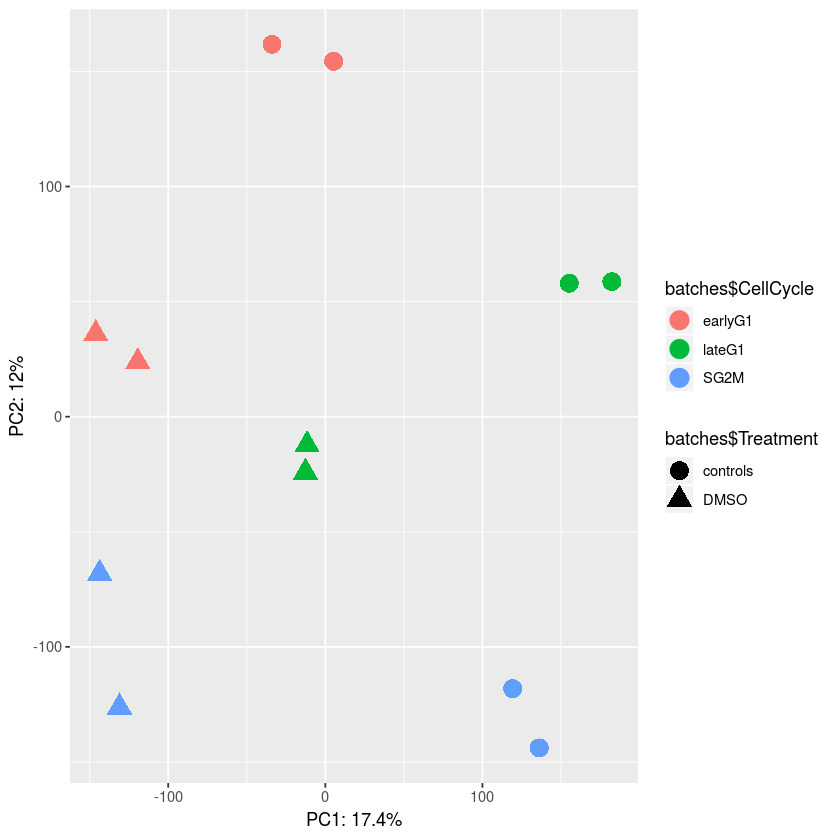

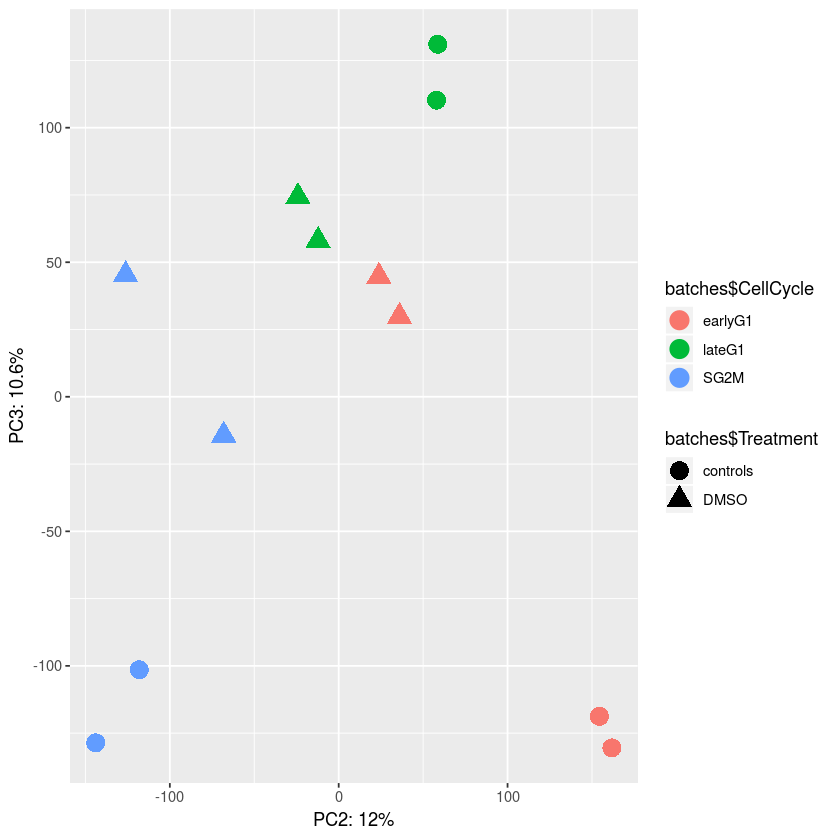

In [13]:
batches=cbind(batches,data.pca$x)

print(ggplot(data=batches,
             aes(x=batches$PC1,
                 y=batches$PC2,
                 label=batches$Rep,
                 shape=batches$Treatment,
                 color=batches$CellCycle))+
    geom_point(size=5)+
    xlab("PC1: 17.4%")+
    ylab("PC2: 12%"))

print(ggplot(data=batches,
             aes(x=batches$PC2,
                 y=batches$PC3,
                 label=batches$Rep,
                 shape=batches$Treatment,
                 color=batches$CellCycle))+
    geom_point(size=5)+
    xlab("PC2: 12%")+
    ylab("PC3: 10.6%"))


In [15]:
write.csv(data_corrected,"atac_corrected.csv")


In [16]:
#We re-run the linear fit on the corrected data 
mod3=model.matrix(~0+Sample,data=batches)
fit2 <- lmFit(data_corrected, mod3)


In [17]:
mod3

,SampleearlyG1_controls,SampleearlyG1_DMSO,SamplelateG1_controls,SamplelateG1_DMSO,SampleSG2M_controls,SampleSG2M_DMSO
earlyG1_controls_Rep1,1,0,0,0,0,0
earlyG1_controls_Rep2,1,0,0,0,0,0
earlyG1_DMSO_Rep1,0,1,0,0,0,0
earlyG1_DMSO_Rep2,0,1,0,0,0,0
lateG1_controls_Rep1,0,0,1,0,0,0
lateG1_controls_Rep2,0,0,1,0,0,0
lateG1_DMSO_Rep1,0,0,0,1,0,0
lateG1_DMSO_Rep2,0,0,0,1,0,0
SG2M_controls_Rep1,0,0,0,0,1,0
SG2M_controls_Rep2,0,0,0,0,1,0


In [18]:
#specify the contrasts 
cont.matrix=makeContrasts(earlyg1_dmso_control="SampleearlyG1_DMSO-SampleearlyG1_controls",
                          lateg1_dmso_control="SamplelateG1_DMSO-SamplelateG1_controls",
                          sg2m_dmso_control="SampleSG2M_DMSO-SampleSG2M_controls",
                          levels=mod3)


In [19]:
fit2=contrasts.fit(fit2,cont.matrix)


In [21]:
e=eBayes(fit2)
comparisons=colnames(cont.matrix)
gene_names=unique_names
for(i in seq(1,3))
{
  tab<-topTable(e, number=nrow(data),coef=i,lfc=1,p.value = 0.05)
  if(nrow(tab)>0)
      {
  names(tab)[1]=comparisons[i]
  tab$Chrom_Start_End=rownames(tab)
  write.table(tab,file=paste("atac_differential_",comparisons[i],".tsv",sep=""),quote=FALSE,sep='\t',row.names = FALSE)
}
    }

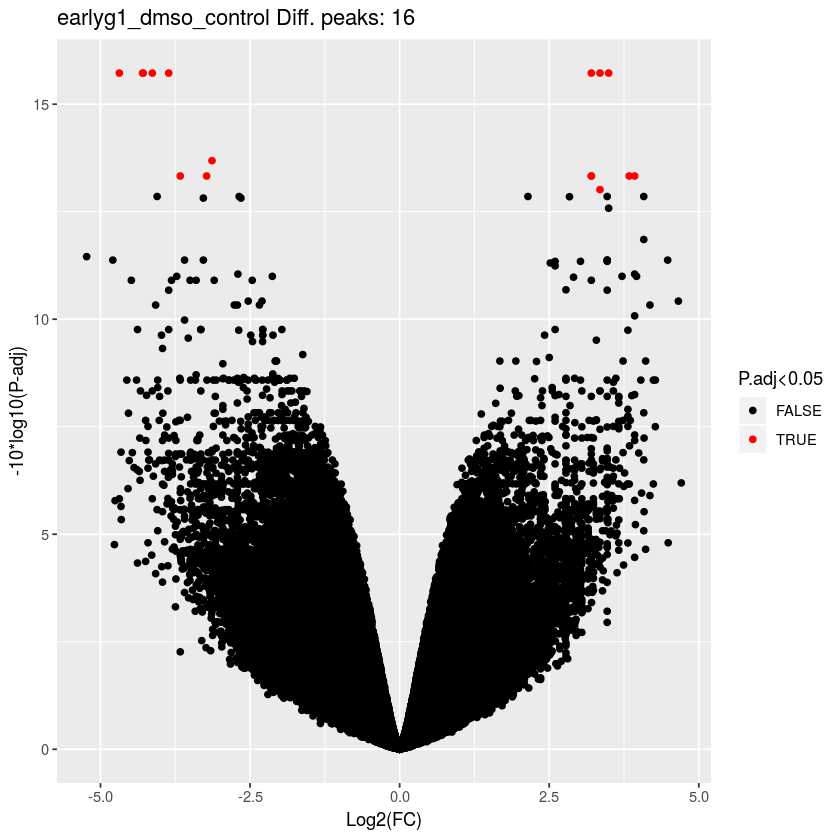

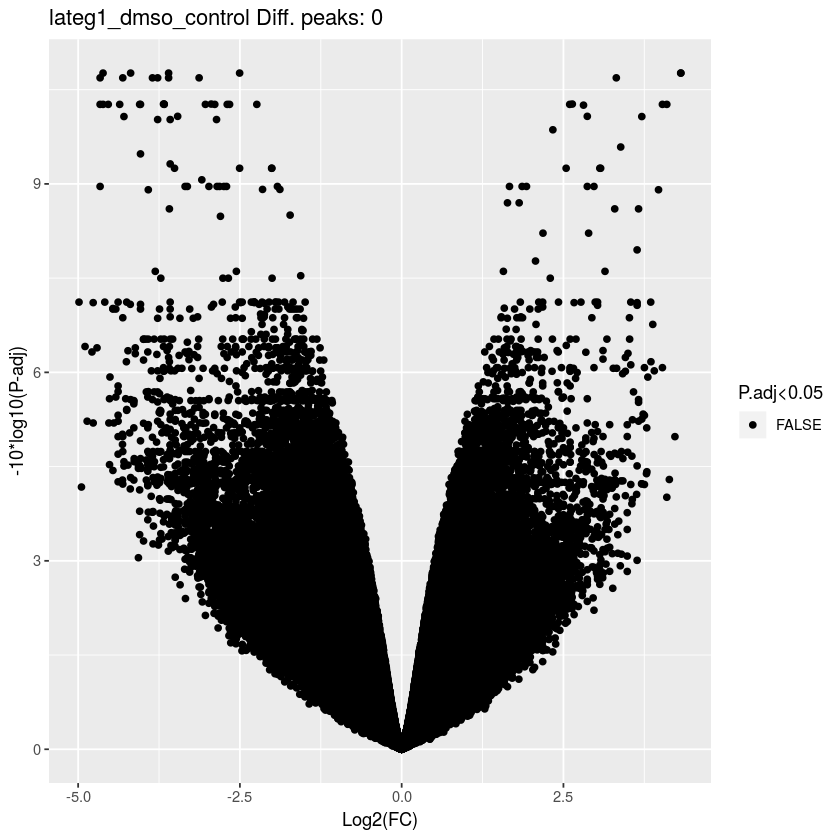

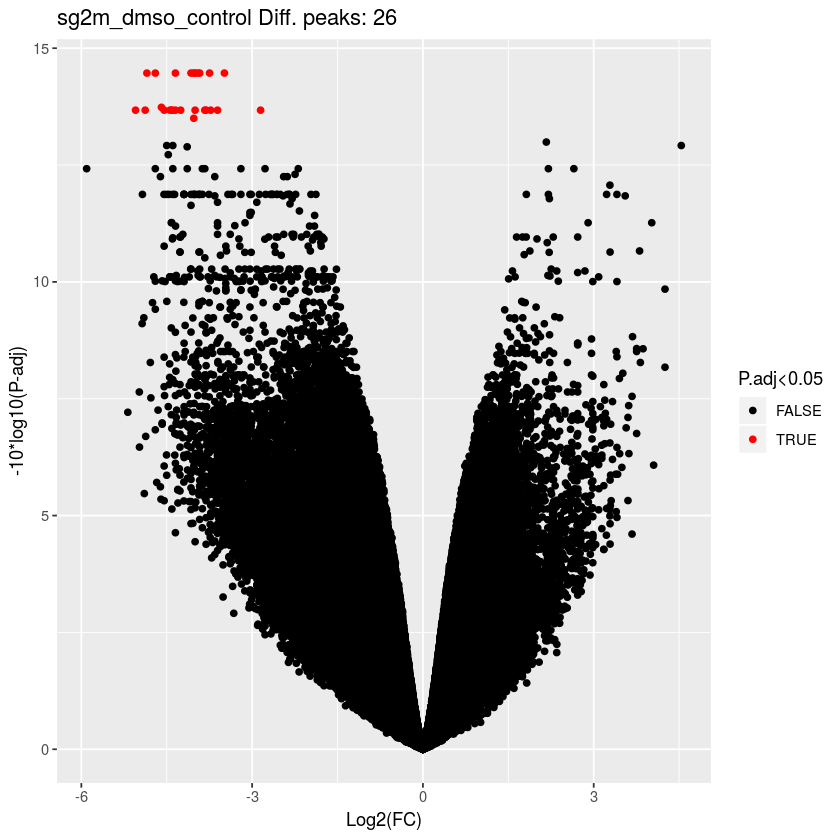

In [22]:
for(i in seq(1,length(comparisons)))
{
 res=as.data.frame(topTable(e, number=nrow(e),coef=i))
 res$logPadj=-10*log10(res$adj.P.Val)
 numsig=sum((abs(res$logFC)>1) & (res$adj.P.Val <= 0.05))
 sigsubset=res[res$adj.P.Val<=0.05,]
 outlabel=paste(comparisons[i],"Diff. peaks:",numsig)
 res$color=res$adj.P.Val<=0.05

 #png(outpng)#,width=5,height=5,pointsize=12)
 print(ggplot(data=res,
        aes(x=res$logFC,
            y=res$logPadj,
            color=res$color))+
        geom_point()+
        xlab("Log2(FC)")+
        ylab("-10*log10(P-adj)")+
        ggtitle(outlabel)+
        scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05"))
}


In [23]:
system("ls",intern=TRUE)

[1] "atac_corrected.csv"                        
[2] "atac.counts.prededup.txt"                  
[3] "atac_differential_earlyg1_dmso_control.tsv"
[4] "atac_differential_sg2m_dmso_control.tsv"   
[5] "Deduped new peaks limma voom no sva.ipynb"

In [24]:
system("cat atac_differential_earlyg1_dmso_control.tsv atac_differential_lateg1_dmso_control.tsv atac_differential_sg2m_dmso_control.tsv | cut -f7 | sort | uniq | sed --expression 's/\\_/\\t/g' | grep -v Chrom | bedtools sort -i stdin > all.diffpeaks.bed",intern=TRUE)

character(0)

In [25]:
system("bedtools closest -d -a all.diffpeaks.bed -b /srv/scratch/annashch/dmso/peak_to_gene_dist/diff_genes.bed | sort |uniq > peaks.closest.bed",intern=TRUE)

character(0)

In [26]:
data=read.table("peaks.closest.bed",header=FALSE,sep='\t')
head(data)


V1,V2,V3,V4,V5,V6,V7,V8
chr10,28212404,28212632,chr10,28339922,28342996,MPP7,127291
chr10,28212404,28212632,chr10,28339922,28343173,MPP7,127291
chr10,28212404,28212632,chr10,28339922,28569071,MPP7,127291
chr10,28212404,28212632,chr10,28339922,28571067,MPP7,127291
chr10,28212404,28212632,chr10,28339922,28623415,MPP7,127291
chr10,33020783,33021022,chr10,35535953,35536058,CCNY,2514932


In [27]:
data$V8[data$V8 < 1]=1
data$V8[data$V8< -1]=1000000

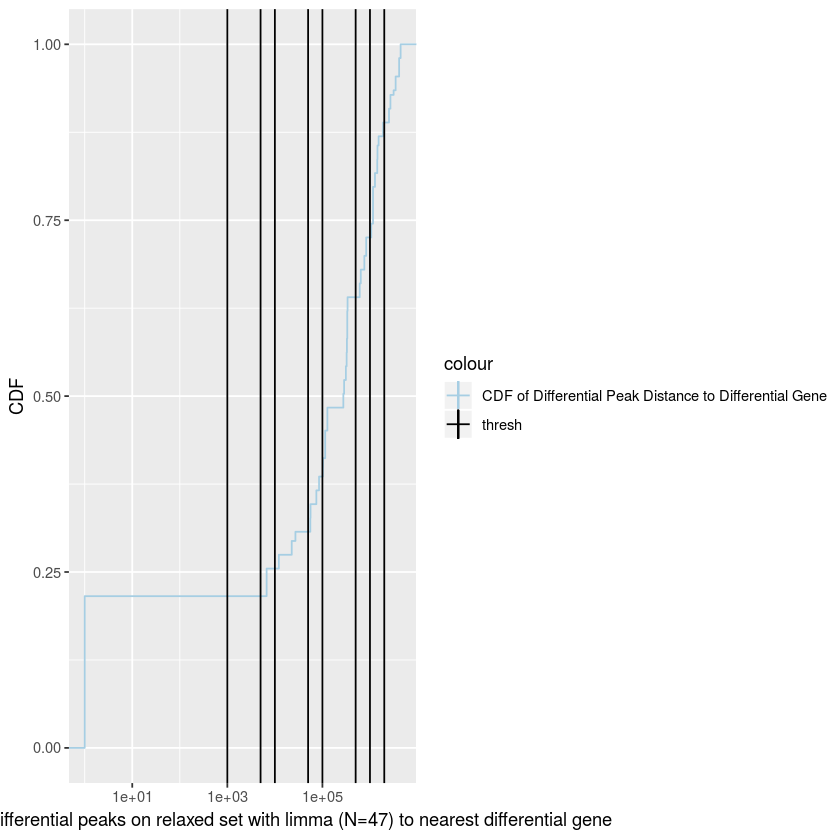

In [28]:
p1=ggplot()+
  stat_ecdf(data=data,aes(x=data$V8 ,color="CDF of Differential Peak Distance to Differential Gene"))+
  geom_vline(aes(xintercept=1000,color="thresh"))+
  geom_vline(aes(xintercept=5000,color="thresh"))+
  geom_vline(aes(xintercept=10000,color="thresh"))+
  geom_vline(aes(xintercept=50000,color="thresh"))+
  geom_vline(aes(xintercept=100000,color="thresh"))+
  geom_vline(aes(xintercept=500000,color="thresh"))+
  geom_vline(aes(xintercept=1000000,color="thresh"))+
  geom_vline(aes(xintercept=2000000,color="thresh"))+
  scale_x_continuous(trans='log10') +
  xlab("Distance from differential peaks on relaxed set with limma (N=47) to nearest differential gene")+
  ylab("CDF")+
scale_color_manual(values=c('#a6cee3','#000000'))

p1